In [1]:
#If th openai api key is not set already, please set it here.
import os
if 'OPENAI_API_KEY' not in os.environ:  
     os.environ['OPENAI_API_KEY'] = ''

In [2]:
from amadeusgpt import AMADEUS
from amadeusgpt.config import Config
from amadeusgpt.utils import parse_result
import amadeusgpt
from amadeusgpt import create_project
import matplotlib.pyplot as plt
import cv2

### Note that unlike other notebooks, we don't have keypoint_file_path here (as it's not provided)
### By default, we use gpt-4o to determine which SuperAnimal models to run and it will run SuperAnimal in the first time the keypoints related queries are asked
### Make sure you use a short video clips if you are not using GPUs in Linux (Mac silicon support to be added)

In [3]:
scene_frame_number = 400

# where you store you video and (optionally) keypoint files
data_folder = "/media1/data/anna/AmadeusGPT/examples/SuperBird"
result_folder = "results"
video_suffix = ".mp4"

config = create_project(data_folder, result_folder, video_suffix = video_suffix)

config["scene_frame_number"] = scene_frame_number

amadeus = AMADEUS(config, use_vlm = True)
video_file_paths = amadeus.get_video_file_paths()
print (video_file_paths)

Project created at results. Results will be saved to results
The project will load video files (*.mp4) and optionally keypoint files from /media1/data/anna/AmadeusGPT/examples/SuperBird
A copy of the project config file is saved at results/config.yaml
{'data_info': {'data_folder': '/media1/data/anna/AmadeusGPT/examples/SuperBird',
               'result_folder': 'results',
               'video_suffix': '.mp4'},
 'keypoint_info': {'include_confidence': False, 'use_3d': False},
 'llm_info': {'keep_last_n_messages': 2,
              'max_tokens': 4096,
              'temperature': 0.0},
 'object_info': {'load_objects_from_disk': False, 'use_grid_objects': False},
 'video_info': {'scene_frame_number': 1},
 'video_suffix': '.mp4'}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0056 $
current input tokens 37018
current accumulated tokens 37135
description of the image frame provided
The image shows two birds perched on a branch. They appear to be looking upwards, and their feathers have a shiny, iridescent quality. The background is a plain, light gray sky, which emphasizes the birds and the branch they are sitting on.

Now, I will fill in the JSON string based on this description:

```json
{
    "description": "Two birds perched on a branch, looking upwards against a light gray sky.",
    "individuals": 2,
    "species": "others",
    "background_objects": ["branch", "sky"]
}
```
['/media1/data/anna/AmadeusGPT/examples/SuperBird/2_birds_superanimal_topviewmouse_hrnetw32.mp4']


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0064 $
current input tokens 2841
current accumulated tokens 40494


To calculate the mean velocity over time per animal and plot it, we can use the `get_velocity()` function from the API to retrieve the velocity data for each animal. The shape of the velocity data will be `(n_frames, n_individuals, n_kpts, n_dim)`, where `n_dim` is 2 for 2D velocity data. 

We will then compute the mean velocity for each animal across all keypoints and plot this mean velocity over time. 

Here's how the code will look:

```python
def plot_mean_velocity(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    tuple: (figure, axs) containing the plot of mean velocity over time for each animal.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get velocity data
    velocity_data = analysis.get_velocity()  # shape: (n_frames, n_individuals, n_kpts, n_dim)
    
    # Calculate mean velocity over time for each animal
    mean_velocity = velocity_data.mean(axis=(2, 3))  # shape: (n_frames, n_individuals)
    # mean_velocity now has shape (n_frames, n_individuals)
    
    # Get the number of frames
    n_frames = analysis.get_data_length()
    
    # Create time array
    time = np.arange(n_frames) / analysis.get_frame_rate()  # time in seconds
    
    # Plotting
    fig, axs = plt.subplots()
    axs.plot(time, mean_velocity[:, 0], label='Animal 0', color='blue')
    axs.plot(time, mean_velocity[:, 1], label='Animal 1', color='orange')
    
    axs.set_title('Mean Velocity Over Time')
    axs.set_xlabel('Time (s)')
    axs.set_ylabel('Mean Velocity')
    axs.set_xlim(0, time[-1])  # x-axis limits
    axs.set_ylim(0, np.max(mean_velocity) * 1.1)  # y-axis limits
    
    axs.legend()
    return fig, axs
```

In this code:
- We retrieve the velocity data and calculate the mean velocity for each animal.
- We create a time array based on the number of frames and the frame rate.
- We plot the mean velocity over time for each animal, ensuring the axes are properly labeled and the limits are set to cover the data.

(<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'Mean Velocity Over Time'}, xlabel='Time (s)', ylabel='Mean Velocity'>)

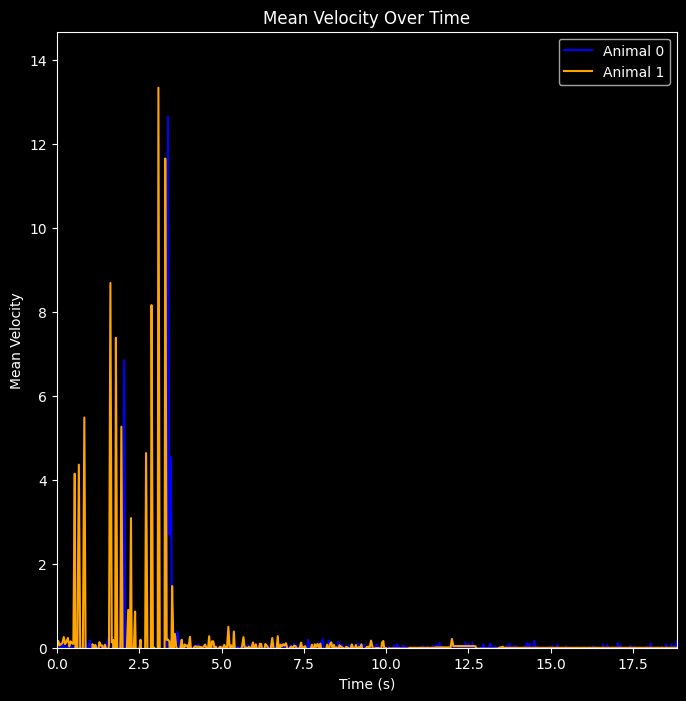

In [4]:
query = "Calculate mean velocity over time per animal and plot it over time"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0073 $
current input tokens 3634
current accumulated tokens 44744


To plot the keypoints and their corresponding labels on top of their corresponding video frames and create an animation, we will use the `get_keypoints()` and `get_scene_image()` functions from the API. 

The steps involved are:
1. Retrieve the keypoints for the animals.
2. Retrieve the scene images (video frames).
3. Create an animation by overlaying the keypoints on the corresponding frames.
4. Save the animation to the current folder.

Here's how the code will look:

```python
def animate_keypoints(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    animation.FuncAnimation: The animation of keypoints over the video frames.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get keypoints data
    keypoints_data = analysis.get_keypoints()  # shape: (n_frames, n_individuals, n_kpts, n_dims)
    n_frames, n_individuals, n_kpts, n_dims = keypoints_data.shape  # unpacking shape
    
    # Prepare the figure for animation
    fig, ax = plt.subplots()
    
    # Function to update the animation
    def update(frame):
        ax.clear()  # Clear the previous frame
        scene_image = analysis.get_scene_image(frame)  # Get the current frame image
        ax.imshow(scene_image)  # Display the image
        
        # Plot keypoints for each animal
        for animal_idx in range(n_individuals):
            keypoints = keypoints_data[frame, animal_idx]  # Get keypoints for the current frame
            for kpt_idx in range(n_kpts):
                x, y = keypoints[kpt_idx]  # Get x, y coordinates of the keypoint
                ax.scatter(x, y, color='red')  # Plot the keypoint
                ax.text(x, y, analysis.get_keypoint_names()[kpt_idx], fontsize=8, color='white')  # Label the keypoint
        
        ax.set_xlim(0, 2560)  # Set x-axis limits
        ax.set_ylim(1440, 0)  # Set y-axis limits (invert y-axis)
        ax.axis('off')  # Turn off the axis

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=n_frames, repeat=False)
    
    # Save the animation
    ani.save('keypoints_animation.mp4', writer='ffmpeg', fps=30)
    
    return ani
```

In this code:
- We retrieve the keypoints and the scene images.
- We define an `update` function that will be called for each frame of the animation, where we plot the keypoints and their labels on the corresponding video frame.
- We create the animation using `FuncAnimation` and save it as an MP4 file in the current folder.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -framerate 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y keypoints_animation.mp4


KeyboardInterrupt: 

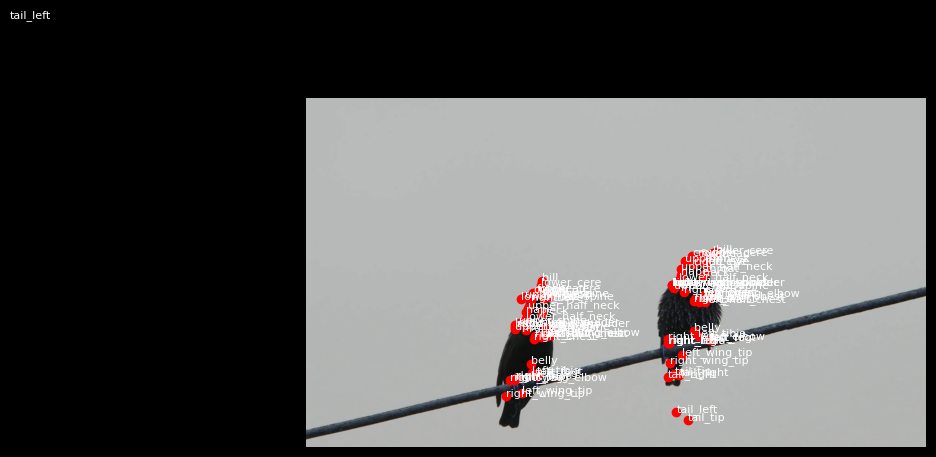

In [5]:
query = "Plot the keypoints and their corresponding labels on top of their corresponding video frame and make an animation and save it to the current folder"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


doing active forgetting


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0081 $
current input tokens 3488
current accumulated tokens 48817


To create an occupancy plot using the animal centers, we will need to calculate the center positions of the animals based on their keypoints. The center can typically be calculated as the average of the x and y coordinates of the keypoints for each animal.

Here are the steps involved:
1. Retrieve the keypoints for the animals.
2. Calculate the center positions for each animal.
3. Create a 2D histogram (occupancy plot) based on the center positions.

Here's how the code will look:

```python
def occupancy_plot(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    tuple: (figure, axs) of the occupancy plot.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get keypoints data
    keypoints_data = analysis.get_keypoints()  # shape: (n_frames, n_individuals, n_kpts, n_dims)
    n_frames, n_individuals, n_kpts, n_dims = keypoints_data.shape  # unpacking shape
    
    # Calculate centers for each animal
    centers = np.mean(keypoints_data[:, :, :, :2], axis=2)  # shape: (n_frames, n_individuals, 2)
    # centers[:, :, 0] is x-coordinates, centers[:, :, 1] is y-coordinates
    
    # Flatten the centers for histogram
    x_centers = centers[:, :, 0].flatten()  # x-coordinates
    y_centers = centers[:, :, 1].flatten()  # y-coordinates
    
    # Create occupancy plot
    fig, ax = plt.subplots()
    hist, xedges, yedges = np.histogram2d(x_centers, y_centers, bins=(50, 50), range=[[0, 2560], [0, 1440]])
    
    # Plot the occupancy
    im = ax.imshow(hist.T, origin='lower', cmap='hot', extent=[0, 2560, 0, 1440])
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Occupancy Plot')
    
    # Add color bar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Occupancy Count')
    
    return fig, ax
```

In this code:
- We retrieve the keypoints and calculate the centers of the animals by averaging their keypoints' x and y coordinates.
- We create a 2D histogram to visualize the occupancy of the animal centers across the frame.
- The occupancy plot is displayed using a heatmap, where the color intensity represents the number of times the centers occupy a particular area in the frame.

(<Figure size 800x800 with 2 Axes>, <Axes: title={'center': 'Occupancy Plot'}, xlabel='X Coordinate', ylabel='Y Coordinate'>)

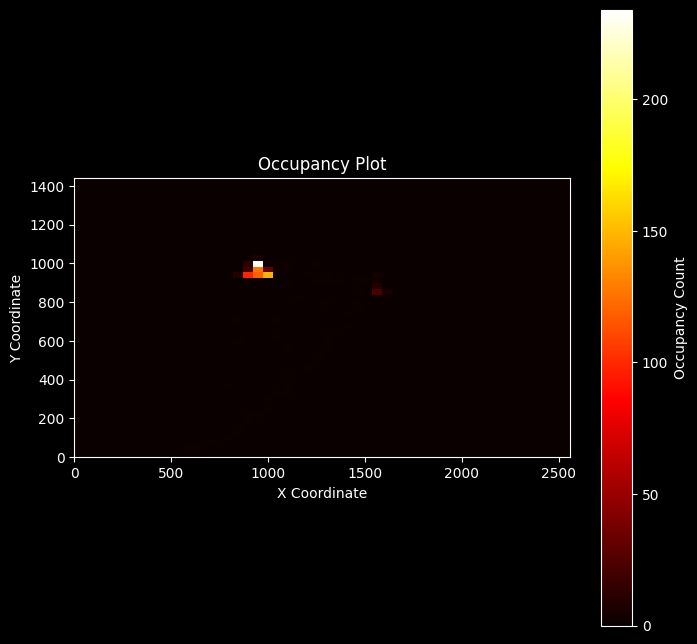

In [6]:
query = "give me the occupancy plot using the animal center"
qa_message = amadeus.step(query)
qa_message = parse_result(amadeus, qa_message)

In [7]:
query = "Give me the number of times the two birds overlap"
qa_message = amadeus.step(query)
qa_message = parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


doing active forgetting


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0088 $
current input tokens 3441
current accumulated tokens 52547


To determine the number of times the two birds overlap, we can use the `get_animals_animals_events` function from the `AnimalBehaviorAnalysis` class. This function allows us to capture events based on spatial queries, such as overlap.

Here's how we can implement this:

1. Use the `get_animals_animals_events` function to query for overlap events between the two birds.
2. Count the number of events returned by this function.

Here's the code to achieve this:

```python
def count_overlap_events(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    int: Number of overlap events between the two birds.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get overlap events between the two birds
    overlap_events = analysis.get_animals_animals_events(
        cross_animal_query_list=['overlap==True'], 
        bodypart_names=None, 
        otheranimal_bodypart_names=None, 
        min_window=10, 
        max_window=1000000
    )
    
    # Return the number of overlap events
    return len(overlap_events)
```

In this code:
- We query for events where the overlap condition is true for the two birds.
- We count the number of events returned and return that count.

2

In [8]:
query = "Calculate the number of wing flaps for each bird"
qa_message = amadeus.step(query)
qa_message = parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


doing active forgetting


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0097 $
current input tokens 3146
current accumulated tokens 56407


To calculate the number of wing flaps for each bird, we need to define what constitutes a "wing flap." Typically, a wing flap can be identified by analyzing the movement of the wing keypoints (e.g., `left_wing_tip`, `right_wing_tip`, etc.) and detecting specific patterns in their motion.

However, since the specific criteria for identifying a wing flap are not provided, I will assume that a wing flap can be detected by observing significant upward and downward movements of the wing keypoints over time.

To implement this, we can follow these steps:

1. Retrieve the keypoints for both birds.
2. Analyze the vertical movement of the wing keypoints to identify flaps.
3. Count the number of flaps for each bird.

Here's how we can implement this:

```python
def count_wing_flaps(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    dict: A dictionary with the number of wing flaps for each bird.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get keypoints for both birds
    keypoints = analysis.get_keypoints()  # Shape: (n_frames, n_individuals, n_kpts, n_dims)
    # Assuming n_individuals is 2 for the two birds
    # keypoints.shape will be (n_frames, 2, n_kpts, 2)
    
    # Get the indices for the wing keypoints
    left_wing_tip_index = analysis.get_keypoint_names().index('left_wing_tip')
    right_wing_tip_index = analysis.get_keypoint_names().index('right_wing_tip')
    
    # Extract the y-coordinates for the wing tips
    left_wing_y = keypoints[:, :, left_wing_tip_index, 1]  # Shape: (n_frames, 2)
    right_wing_y = keypoints[:, :, right_wing_tip_index, 1]  # Shape: (n_frames, 2)
    
    # Count flaps based on significant changes in y-coordinates
    def count_flaps(wing_y):
        # Calculate the difference in y-coordinates
        y_diff = np.diff(wing_y, axis=0)  # Shape: (n_frames-1, 2)
        # Count upward and downward movements (flaps)
        flaps = np.sum((y_diff[:-1] > 0) & (y_diff[1:] < 0)) + np.sum((y_diff[:-1] < 0) & (y_diff[1:] > 0))
        return flaps
    
    left_flaps = count_flaps(left_wing_y)
    right_flaps = count_flaps(right_wing_y)
    
    return {
        'animal_0': left_flaps,
        'animal_1': right_flaps
    }
```

In this code:
- We retrieve the keypoints for both birds and extract the y-coordinates of the wing tips.
- We define a function `count_flaps` that counts the number of upward and downward movements, which we consider as flaps.
- Finally, we return a dictionary with the number of flaps for each bird. 

Please note that the criteria for counting flaps may need to be adjusted based on specific definitions or thresholds for what constitutes a flap.

{'animal_0': 380, 'animal_1': 398}

In [11]:
query = "Produce a visualization of the direction of movement for the bird that moves and save it as an animation to this folder /media1/data/anna/AmadeusGPT/examples/SuperBird"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


doing active forgetting


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0135 $
current input tokens 3566
current accumulated tokens 72172


To create a visualization of the direction of movement for the bird that is moving, we will follow a similar approach as before, but this time we will also display the animation in a separate window after saving it. 

Here's how we can implement this:

1. Retrieve the keypoints and speed data for the birds.
2. Identify which bird is moving based on the speed data.
3. Create an animation that shows the movement of the keypoints for the moving bird.
4. Save the animation to the current folder.
5. Display the animation in a separate window.

Here's the code to achieve this:

```python
def animate_bird_movement(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    animation.FuncAnimation: The animation object showing the bird's movement.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get keypoints and speed data
    keypoints = analysis.get_keypoints()  # Shape: (n_frames, n_individuals, n_kpts, n_dims)
    speed = analysis.get_speed()  # Shape: (n_frames, n_individuals, n_kpts, 1)
    
    # Identify which bird is moving
    moving_bird_index = np.argmax(speed.mean(axis=2))  # Index of the bird with the highest average speed
    
    # Prepare data for animation
    n_frames = keypoints.shape[0]  # Number of frames
    moving_bird_keypoints = keypoints[:, moving_bird_index]  # Shape: (n_frames, n_kpts, n_dims)
    
    # Create the animation
    fig, ax = plt.subplots()
    ax.set_xlim(0, 2560)  # Width of the image
    ax.set_ylim(0, 1440)  # Height of the image
    ax.invert_yaxis()  # Invert y-axis for correct orientation
    
    # Initialize lines for keypoints
    lines = [ax.plot([], [], 'o')[0] for _ in range(moving_bird_keypoints.shape[1])]  # One line for each keypoint
    
    def init():
        for line in lines:
            line.set_data([], [])
        return lines
    
    def update(frame):
        for i, line in enumerate(lines):
            line.set_data(moving_bird_keypoints[frame, i, 0], moving_bird_keypoints[frame, i, 1])
        return lines
    
    ani = animation.FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True)
    
    # Save the animation
    ani.save('bird_movement_animation.mp4', writer='ffmpeg', fps=30)
    
    # Show the animation in a separate window
    plt.show()
    
    return ani
```

In this code:
- We retrieve the keypoints and speed data for the birds.
- We identify the moving bird by finding the index of the bird with the highest average speed.
- We create an animation that updates the position of the keypoints for the moving bird over time.
- We save the animation as an MP4 file in the current folder.
- Finally, we display the animation in a separate window using `plt.show()`.

This will allow you to visualize the movement direction of the active bird while also saving the animation for future reference.

error occurs in code execution
Traceback (most recent call last):
  File "/media1/data/anna/AmadeusGPT/amadeusgpt/programs/sandbox.py", line 350, in code_execution
    exec(f"result = {call_str}", namespace)
  File "<string>", line 1, in <module>
  File "<string>", line 24, in animate_bird_movement
IndexError: index 149 is out of bounds for axis 1 with size 2

the code that gave errors was 
def animate_bird_movement(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    animation.FuncAnimation: The animation object showing the bird's movement.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get keypoints and speed data
    keypoints = analysis.get_keypoints()  # Shape: (n_frames, n_individuals, n_kpts, n_dims)
    speed = analysis.get_speed()  # Shape: (n_frames, n_individuals, n_kpts, 1)
 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0141 $
current input tokens 2000
current accumulated tokens 74719
```python
def animate_bird_movement(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    animation.FuncAnimation: The animation object showing the bird's movement.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get keypoints and speed data
    keypoints = analysis.get_keypoints()  # Shape: (n_frames, n_individuals, n_kpts, n_dims)
    speed = analysis.get_speed()  # Shape: (n_frames, n_individuals, n_kpts, 1)
    
    # Identify which bird is moving
    moving_bird_index = np.argmax(speed.mean(axis=2))  # Index of the bird with the highest average speed
    
    # Ensure the moving_bird_index is within bounds
    n_individuals = keypoints.shape[1]
    if moving_bird_index >= n_individuals:
        rais

[]